# Import bibliotek

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

import torch
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
from timeit import default_timer as timer 

import os

from typing import List, Dict

In [3]:
import sys
sys.path.append("../src/")

from data_setup import create_dataloaders
from model_builder import HybridModel
from engine import train_step, test_step, train

# Wczytanie danych

In [4]:
df = pd.read_csv("../data/datasets_sum.csv")
df

,Emotion,Path,Dataset,Emotion_mapped
0,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Crema,0
1,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Crema,0
2,NEUTRAL,../data/kaggle/input/speech-emotion-recognitio...,Crema,1
3,NEUTRAL,../data/kaggle/input/speech-emotion-recognitio...,Crema,1
4,DISGUST,../data/kaggle/input/speech-emotion-recognitio...,Crema,2
...,...,...,...,...
9390,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9391,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9392,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0
9393,ANGRY,../data/kaggle/input/speech-emotion-recognitio...,Tess,0


In [5]:
df = df[df["Dataset"]=="Crema"].reset_index(drop=True)

In [6]:
SAMPLE_RATE = 44100
SEED = 42

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df["Emotion_mapped"], random_state=SEED)

In [8]:
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [9]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dataframe=train_df, 
    test_dataframe=test_df, 
    original_transform=original_transform, 
    augment_transform=augment_transform,
    batch_size=32
)

In [10]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x105604cb0>,
 array(['FEAR', 'ANGRY', 'NEUTRAL', 'HAPPY', 'DISGUST'], dtype=object))

# Model

## Uczenie

In [11]:
from data_setup import create_dataloaders
from engine import train_step, test_step, train

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

torch.manual_seed(SEED) 
torch.mps.manual_seed(SEED)

NUM_EPOCHS = 100

model = HybridModel(num_emotions=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

start_time = timer()

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=NUM_EPOCHS,
                      device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  1%|          | 1/100 [02:47<4:35:33, 167.01s/it]

Epoch: 1 | train_loss: 1.4955 | train_acc: 0.3325 | test_loss: 2.0130 | test_acc: 0.2058


  2%|▏         | 2/100 [05:24<4:23:17, 161.20s/it]

Epoch: 2 | train_loss: 1.3744 | train_acc: 0.4009 | test_loss: 1.8889 | test_acc: 0.1366


  3%|▎         | 3/100 [08:00<4:17:21, 159.19s/it]

Epoch: 3 | train_loss: 1.3454 | train_acc: 0.4212 | test_loss: 2.1157 | test_acc: 0.1576


  4%|▍         | 4/100 [10:37<4:12:53, 158.05s/it]

Epoch: 4 | train_loss: 1.3246 | train_acc: 0.4406 | test_loss: 2.0771 | test_acc: 0.1944


  5%|▌         | 5/100 [13:14<4:09:41, 157.70s/it]

Epoch: 5 | train_loss: 1.3086 | train_acc: 0.4489 | test_loss: 2.0475 | test_acc: 0.1922


  6%|▌         | 6/100 [15:51<4:06:57, 157.63s/it]

Epoch: 6 | train_loss: 1.2897 | train_acc: 0.4610 | test_loss: 2.1050 | test_acc: 0.2004


  7%|▋         | 7/100 [18:28<4:04:03, 157.46s/it]

Epoch: 7 | train_loss: 1.2833 | train_acc: 0.4621 | test_loss: 2.0950 | test_acc: 0.1943


  8%|▊         | 8/100 [21:06<4:01:15, 157.34s/it]

Epoch: 8 | train_loss: 1.2658 | train_acc: 0.4730 | test_loss: 2.0704 | test_acc: 0.1987


  9%|▉         | 9/100 [26:30<5:17:48, 209.54s/it]

Epoch: 9 | train_loss: 1.2710 | train_acc: 0.4700 | test_loss: 1.9902 | test_acc: 0.2024


 10%|█         | 10/100 [29:08<4:50:25, 193.61s/it]

Epoch: 10 | train_loss: 1.2585 | train_acc: 0.4787 | test_loss: 2.1504 | test_acc: 0.1987


 11%|█         | 11/100 [31:47<4:31:21, 182.93s/it]

Epoch: 11 | train_loss: 1.2468 | train_acc: 0.4831 | test_loss: 1.9855 | test_acc: 0.2160


 12%|█▏        | 12/100 [34:24<4:17:03, 175.27s/it]

Epoch: 12 | train_loss: 1.2468 | train_acc: 0.4812 | test_loss: 2.0659 | test_acc: 0.2047


 13%|█▎        | 13/100 [37:06<4:08:06, 171.11s/it]

Epoch: 13 | train_loss: 1.2402 | train_acc: 0.4905 | test_loss: 2.1936 | test_acc: 0.1998


 14%|█▍        | 14/100 [39:48<4:01:22, 168.40s/it]

Epoch: 14 | train_loss: 1.2325 | train_acc: 0.4929 | test_loss: 1.9460 | test_acc: 0.2154


 15%|█▌        | 15/100 [42:29<3:55:28, 166.22s/it]

Epoch: 15 | train_loss: 1.2231 | train_acc: 0.4982 | test_loss: 2.0819 | test_acc: 0.2003


 16%|█▌        | 16/100 [45:08<3:49:49, 164.17s/it]

Epoch: 16 | train_loss: 1.2175 | train_acc: 0.4986 | test_loss: 2.2842 | test_acc: 0.1977


 17%|█▋        | 17/100 [47:46<3:44:26, 162.25s/it]

Epoch: 17 | train_loss: 1.2175 | train_acc: 0.4950 | test_loss: 2.0961 | test_acc: 0.2122


 18%|█▊        | 18/100 [50:24<3:39:47, 160.82s/it]

Epoch: 18 | train_loss: 1.2056 | train_acc: 0.5045 | test_loss: 2.1307 | test_acc: 0.2014


 19%|█▉        | 19/100 [53:03<3:36:16, 160.21s/it]

Epoch: 19 | train_loss: 1.2067 | train_acc: 0.5059 | test_loss: 2.0974 | test_acc: 0.2133


 20%|██        | 20/100 [55:40<3:32:24, 159.31s/it]

Epoch: 20 | train_loss: 1.1996 | train_acc: 0.5100 | test_loss: 2.0415 | test_acc: 0.2246


 21%|██        | 21/100 [1:00:45<4:27:33, 203.21s/it]

Epoch: 21 | train_loss: 1.1954 | train_acc: 0.5105 | test_loss: 2.1348 | test_acc: 0.2025


 22%|██▏       | 22/100 [1:03:26<4:07:38, 190.49s/it]

Epoch: 22 | train_loss: 1.1866 | train_acc: 0.5168 | test_loss: 2.1005 | test_acc: 0.2144


 23%|██▎       | 23/100 [1:06:03<3:51:38, 180.50s/it]

Epoch: 23 | train_loss: 1.1840 | train_acc: 0.5166 | test_loss: 2.0441 | test_acc: 0.2106


 24%|██▍       | 24/100 [1:08:41<3:40:03, 173.73s/it]

Epoch: 24 | train_loss: 1.1763 | train_acc: 0.5250 | test_loss: 2.0095 | test_acc: 0.2154


 25%|██▌       | 25/100 [1:11:19<3:31:13, 168.98s/it]

Epoch: 25 | train_loss: 1.1638 | train_acc: 0.5293 | test_loss: 2.1120 | test_acc: 0.1929


 26%|██▌       | 26/100 [1:20:41<5:53:40, 286.76s/it]

Epoch: 26 | train_loss: 1.1685 | train_acc: 0.5264 | test_loss: 2.2663 | test_acc: 0.1939


 27%|██▋       | 27/100 [1:31:40<8:04:48, 398.48s/it]

Epoch: 27 | train_loss: 1.1501 | train_acc: 0.5309 | test_loss: 2.3167 | test_acc: 0.1873


 28%|██▊       | 28/100 [1:34:16<6:30:50, 325.71s/it]

Epoch: 28 | train_loss: 1.1575 | train_acc: 0.5285 | test_loss: 2.3888 | test_acc: 0.2095


 29%|██▉       | 29/100 [1:36:53<5:25:26, 275.02s/it]

Epoch: 29 | train_loss: 1.1524 | train_acc: 0.5348 | test_loss: 2.4130 | test_acc: 0.1987


 30%|███       | 30/100 [1:39:30<4:39:52, 239.89s/it]

Epoch: 30 | train_loss: 1.1493 | train_acc: 0.5376 | test_loss: 2.4215 | test_acc: 0.1868


 31%|███       | 31/100 [1:42:10<4:08:03, 215.70s/it]

Epoch: 31 | train_loss: 1.1448 | train_acc: 0.5337 | test_loss: 2.2727 | test_acc: 0.1770


 32%|███▏      | 32/100 [1:44:48<3:45:05, 198.61s/it]

Epoch: 32 | train_loss: 1.1403 | train_acc: 0.5421 | test_loss: 2.2346 | test_acc: 0.1863


 33%|███▎      | 33/100 [1:47:29<3:29:03, 187.21s/it]

Epoch: 33 | train_loss: 1.1344 | train_acc: 0.5439 | test_loss: 2.4841 | test_acc: 0.1917


 34%|███▍      | 34/100 [1:50:07<3:16:23, 178.54s/it]

Epoch: 34 | train_loss: 1.1312 | train_acc: 0.5417 | test_loss: 2.3498 | test_acc: 0.2004


 35%|███▌      | 35/100 [1:52:45<3:06:31, 172.18s/it]

Epoch: 35 | train_loss: 1.1126 | train_acc: 0.5499 | test_loss: 2.4039 | test_acc: 0.1960


 36%|███▌      | 36/100 [1:55:22<2:58:58, 167.79s/it]

Epoch: 36 | train_loss: 1.1136 | train_acc: 0.5530 | test_loss: 2.3846 | test_acc: 0.1625


 37%|███▋      | 37/100 [1:58:01<2:53:28, 165.22s/it]

Epoch: 37 | train_loss: 1.1114 | train_acc: 0.5519 | test_loss: 2.2809 | test_acc: 0.1652


 38%|███▊      | 38/100 [2:00:40<2:48:45, 163.31s/it]

Epoch: 38 | train_loss: 1.1026 | train_acc: 0.5624 | test_loss: 2.3138 | test_acc: 0.1907


 39%|███▉      | 39/100 [2:03:18<2:44:23, 161.70s/it]

Epoch: 39 | train_loss: 1.1002 | train_acc: 0.5570 | test_loss: 2.4078 | test_acc: 0.1902


 40%|████      | 40/100 [2:05:56<2:40:32, 160.54s/it]

Epoch: 40 | train_loss: 1.0960 | train_acc: 0.5582 | test_loss: 2.7128 | test_acc: 0.1912


 41%|████      | 41/100 [2:08:33<2:36:52, 159.54s/it]

Epoch: 41 | train_loss: 1.0913 | train_acc: 0.5652 | test_loss: 2.4200 | test_acc: 0.1890


 42%|████▏     | 42/100 [2:11:11<2:33:38, 158.94s/it]

Epoch: 42 | train_loss: 1.0911 | train_acc: 0.5588 | test_loss: 2.4867 | test_acc: 0.1955


 43%|████▎     | 43/100 [2:13:49<2:30:45, 158.69s/it]

Epoch: 43 | train_loss: 1.0816 | train_acc: 0.5684 | test_loss: 2.5527 | test_acc: 0.1637


 44%|████▍     | 44/100 [2:16:27<2:27:47, 158.35s/it]

Epoch: 44 | train_loss: 1.0810 | train_acc: 0.5619 | test_loss: 2.3420 | test_acc: 0.1750


 45%|████▌     | 45/100 [2:19:59<2:40:08, 174.70s/it]

Epoch: 45 | train_loss: 1.0753 | train_acc: 0.5683 | test_loss: 2.3628 | test_acc: 0.1576


 46%|████▌     | 46/100 [2:38:25<6:48:33, 453.95s/it]

Epoch: 46 | train_loss: 1.0625 | train_acc: 0.5732 | test_loss: 2.4815 | test_acc: 0.1652


 47%|████▋     | 47/100 [2:41:03<5:22:40, 365.30s/it]

Epoch: 47 | train_loss: 1.0776 | train_acc: 0.5682 | test_loss: 2.4448 | test_acc: 0.1884


 48%|████▊     | 48/100 [2:43:41<4:22:39, 303.06s/it]

Epoch: 48 | train_loss: 1.0766 | train_acc: 0.5700 | test_loss: 2.4469 | test_acc: 0.1695


 49%|████▉     | 49/100 [2:46:20<3:40:42, 259.66s/it]

Epoch: 49 | train_loss: 1.0548 | train_acc: 0.5799 | test_loss: 2.6229 | test_acc: 0.1923


 50%|█████     | 50/100 [2:48:57<3:10:51, 229.04s/it]

Epoch: 50 | train_loss: 1.0604 | train_acc: 0.5765 | test_loss: 2.3786 | test_acc: 0.1733


 51%|█████     | 51/100 [2:51:34<2:49:23, 207.43s/it]

Epoch: 51 | train_loss: 1.0491 | train_acc: 0.5814 | test_loss: 2.4998 | test_acc: 0.1890


 52%|█████▏    | 52/100 [2:54:11<2:33:47, 192.23s/it]

Epoch: 52 | train_loss: 1.0381 | train_acc: 0.5879 | test_loss: 2.6922 | test_acc: 0.1593


 53%|█████▎    | 53/100 [2:56:49<2:22:33, 181.98s/it]

Epoch: 53 | train_loss: 1.0373 | train_acc: 0.5917 | test_loss: 2.6443 | test_acc: 0.1954


 54%|█████▍    | 54/100 [2:59:26<2:13:49, 174.55s/it]

Epoch: 54 | train_loss: 1.0296 | train_acc: 0.5945 | test_loss: 2.4592 | test_acc: 0.1561


 55%|█████▌    | 55/100 [3:02:05<2:07:16, 169.71s/it]

Epoch: 55 | train_loss: 1.0334 | train_acc: 0.5871 | test_loss: 2.3934 | test_acc: 0.1793


 56%|█████▌    | 56/100 [3:04:42<2:01:45, 166.03s/it]

Epoch: 56 | train_loss: 1.0234 | train_acc: 0.5921 | test_loss: 2.5765 | test_acc: 0.1868


 57%|█████▋    | 57/100 [3:07:20<1:57:20, 163.74s/it]

Epoch: 57 | train_loss: 1.0266 | train_acc: 0.5846 | test_loss: 2.4045 | test_acc: 0.1679


 58%|█████▊    | 58/100 [3:09:58<1:53:22, 161.96s/it]

Epoch: 58 | train_loss: 1.0194 | train_acc: 0.5919 | test_loss: 2.6029 | test_acc: 0.1713


 59%|█████▉    | 59/100 [3:13:00<1:54:43, 167.88s/it]

Epoch: 59 | train_loss: 1.0225 | train_acc: 0.5937 | test_loss: 2.8023 | test_acc: 0.1740


 60%|██████    | 60/100 [3:15:48<1:52:01, 168.05s/it]

Epoch: 60 | train_loss: 1.0126 | train_acc: 0.5986 | test_loss: 2.8466 | test_acc: 0.1772


 61%|██████    | 61/100 [3:18:33<1:48:33, 167.01s/it]

Epoch: 61 | train_loss: 1.0136 | train_acc: 0.5988 | test_loss: 2.5567 | test_acc: 0.1852


 62%|██████▏   | 62/100 [3:21:16<1:45:05, 165.94s/it]

Epoch: 62 | train_loss: 1.0195 | train_acc: 0.5990 | test_loss: 2.5778 | test_acc: 0.1621


 63%|██████▎   | 63/100 [3:23:59<1:41:46, 165.04s/it]

Epoch: 63 | train_loss: 1.0024 | train_acc: 0.6051 | test_loss: 2.7281 | test_acc: 0.1713


 64%|██████▍   | 64/100 [3:26:41<1:38:24, 164.02s/it]

Epoch: 64 | train_loss: 1.0076 | train_acc: 0.6020 | test_loss: 2.7367 | test_acc: 0.1598


 65%|██████▌   | 65/100 [3:29:23<1:35:21, 163.48s/it]

Epoch: 65 | train_loss: 0.9973 | train_acc: 0.6094 | test_loss: 2.6826 | test_acc: 0.1382


 66%|██████▌   | 66/100 [3:32:04<1:32:11, 162.69s/it]

Epoch: 66 | train_loss: 0.9953 | train_acc: 0.6045 | test_loss: 2.8026 | test_acc: 0.1555


 67%|██████▋   | 67/100 [3:34:54<1:30:42, 164.92s/it]

Epoch: 67 | train_loss: 0.9955 | train_acc: 0.6043 | test_loss: 2.9709 | test_acc: 0.1636


 68%|██████▊   | 68/100 [3:38:09<1:32:45, 173.91s/it]

Epoch: 68 | train_loss: 0.9889 | train_acc: 0.6126 | test_loss: 2.6483 | test_acc: 0.1636


 69%|██████▉   | 69/100 [3:41:04<1:29:58, 174.16s/it]

Epoch: 69 | train_loss: 0.9876 | train_acc: 0.6099 | test_loss: 2.7437 | test_acc: 0.1668


 70%|███████   | 70/100 [3:43:52<1:26:09, 172.30s/it]

Epoch: 70 | train_loss: 0.9830 | train_acc: 0.6152 | test_loss: 2.5962 | test_acc: 0.1646


 71%|███████   | 71/100 [3:46:36<1:22:10, 170.01s/it]

Epoch: 71 | train_loss: 0.9719 | train_acc: 0.6159 | test_loss: 2.7915 | test_acc: 0.1733


 72%|███████▏  | 72/100 [3:49:21<1:18:30, 168.24s/it]

Epoch: 72 | train_loss: 0.9671 | train_acc: 0.6185 | test_loss: 2.8790 | test_acc: 0.1566


 73%|███████▎  | 73/100 [3:52:03<1:14:56, 166.55s/it]

Epoch: 73 | train_loss: 0.9621 | train_acc: 0.6118 | test_loss: 2.6658 | test_acc: 0.1766


 74%|███████▍  | 74/100 [3:54:46<1:11:39, 165.37s/it]

Epoch: 74 | train_loss: 0.9733 | train_acc: 0.6133 | test_loss: 2.8821 | test_acc: 0.1543


 75%|███████▌  | 75/100 [3:57:27<1:08:22, 164.09s/it]

Epoch: 75 | train_loss: 0.9725 | train_acc: 0.6201 | test_loss: 2.6374 | test_acc: 0.1928


 76%|███████▌  | 76/100 [4:00:08<1:05:19, 163.33s/it]

Epoch: 76 | train_loss: 0.9680 | train_acc: 0.6139 | test_loss: 2.7639 | test_acc: 0.1624


 77%|███████▋  | 77/100 [4:02:50<1:02:24, 162.79s/it]

Epoch: 77 | train_loss: 0.9600 | train_acc: 0.6129 | test_loss: 2.9193 | test_acc: 0.1716


 78%|███████▊  | 78/100 [4:05:32<59:33, 162.45s/it]  

Epoch: 78 | train_loss: 0.9601 | train_acc: 0.6183 | test_loss: 2.6855 | test_acc: 0.1804


 79%|███████▉  | 79/100 [4:08:15<56:58, 162.77s/it]

Epoch: 79 | train_loss: 0.9518 | train_acc: 0.6216 | test_loss: 2.8820 | test_acc: 0.1696


 80%|████████  | 80/100 [4:11:00<54:29, 163.48s/it]

Epoch: 80 | train_loss: 0.9512 | train_acc: 0.6216 | test_loss: 2.6816 | test_acc: 0.1511


 81%|████████  | 81/100 [4:13:46<52:00, 164.22s/it]

Epoch: 81 | train_loss: 0.9479 | train_acc: 0.6259 | test_loss: 2.9049 | test_acc: 0.1566


 82%|████████▏ | 82/100 [4:16:33<49:31, 165.10s/it]

Epoch: 82 | train_loss: 0.9443 | train_acc: 0.6298 | test_loss: 3.0317 | test_acc: 0.1713


 83%|████████▎ | 83/100 [4:19:22<47:02, 166.01s/it]

Epoch: 83 | train_loss: 0.9536 | train_acc: 0.6240 | test_loss: 2.9987 | test_acc: 0.1710


 84%|████████▍ | 84/100 [4:22:11<44:32, 167.03s/it]

Epoch: 84 | train_loss: 0.9409 | train_acc: 0.6268 | test_loss: 2.7721 | test_acc: 0.1878


 85%|████████▌ | 85/100 [4:25:00<41:53, 167.59s/it]

Epoch: 85 | train_loss: 0.9509 | train_acc: 0.6292 | test_loss: 2.7639 | test_acc: 0.1646


 86%|████████▌ | 86/100 [4:27:50<39:15, 168.22s/it]

Epoch: 86 | train_loss: 0.9333 | train_acc: 0.6296 | test_loss: 2.7078 | test_acc: 0.1594


 87%|████████▋ | 87/100 [4:30:38<36:29, 168.41s/it]

Epoch: 87 | train_loss: 0.9290 | train_acc: 0.6311 | test_loss: 2.8773 | test_acc: 0.1538


 88%|████████▊ | 88/100 [4:33:28<33:44, 168.67s/it]

Epoch: 88 | train_loss: 0.9408 | train_acc: 0.6303 | test_loss: 3.0007 | test_acc: 0.1587


 89%|████████▉ | 89/100 [4:36:18<31:01, 169.19s/it]

Epoch: 89 | train_loss: 0.9331 | train_acc: 0.6307 | test_loss: 2.7670 | test_acc: 0.1609


 90%|█████████ | 90/100 [4:39:08<28:14, 169.44s/it]

Epoch: 90 | train_loss: 0.9281 | train_acc: 0.6343 | test_loss: 2.7967 | test_acc: 0.1619


 91%|█████████ | 91/100 [4:42:00<25:31, 170.14s/it]

Epoch: 91 | train_loss: 0.9253 | train_acc: 0.6349 | test_loss: 2.9755 | test_acc: 0.1706


 92%|█████████▏| 92/100 [4:44:51<22:43, 170.43s/it]

Epoch: 92 | train_loss: 0.9239 | train_acc: 0.6346 | test_loss: 2.8083 | test_acc: 0.1700


 93%|█████████▎| 93/100 [4:47:41<19:51, 170.22s/it]

Epoch: 93 | train_loss: 0.9188 | train_acc: 0.6421 | test_loss: 3.2456 | test_acc: 0.1718


 94%|█████████▍| 94/100 [4:50:30<17:00, 170.09s/it]

Epoch: 94 | train_loss: 0.9220 | train_acc: 0.6308 | test_loss: 2.8580 | test_acc: 0.1534


 95%|█████████▌| 95/100 [4:53:20<14:09, 169.82s/it]

Epoch: 95 | train_loss: 0.9137 | train_acc: 0.6346 | test_loss: 2.9469 | test_acc: 0.1404


 96%|█████████▌| 96/100 [4:56:08<11:17, 169.38s/it]

Epoch: 96 | train_loss: 0.9244 | train_acc: 0.6366 | test_loss: 3.0332 | test_acc: 0.1545


 97%|█████████▋| 97/100 [4:58:55<08:26, 168.74s/it]

Epoch: 97 | train_loss: 0.9119 | train_acc: 0.6431 | test_loss: 2.8428 | test_acc: 0.1566


 98%|█████████▊| 98/100 [5:01:42<05:36, 168.26s/it]

Epoch: 98 | train_loss: 0.9090 | train_acc: 0.6428 | test_loss: 2.8690 | test_acc: 0.1640


 99%|█████████▉| 99/100 [5:04:30<02:48, 168.21s/it]

Epoch: 99 | train_loss: 0.9067 | train_acc: 0.6451 | test_loss: 2.8000 | test_acc: 0.1705


100%|██████████| 100/100 [5:07:18<00:00, 184.39s/it]

Epoch: 100 | train_loss: 0.9064 | train_acc: 0.6383 | test_loss: 2.9919 | test_acc: 0.1770
Total training time: 16233.055 seconds


In [12]:
# Check the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [13]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

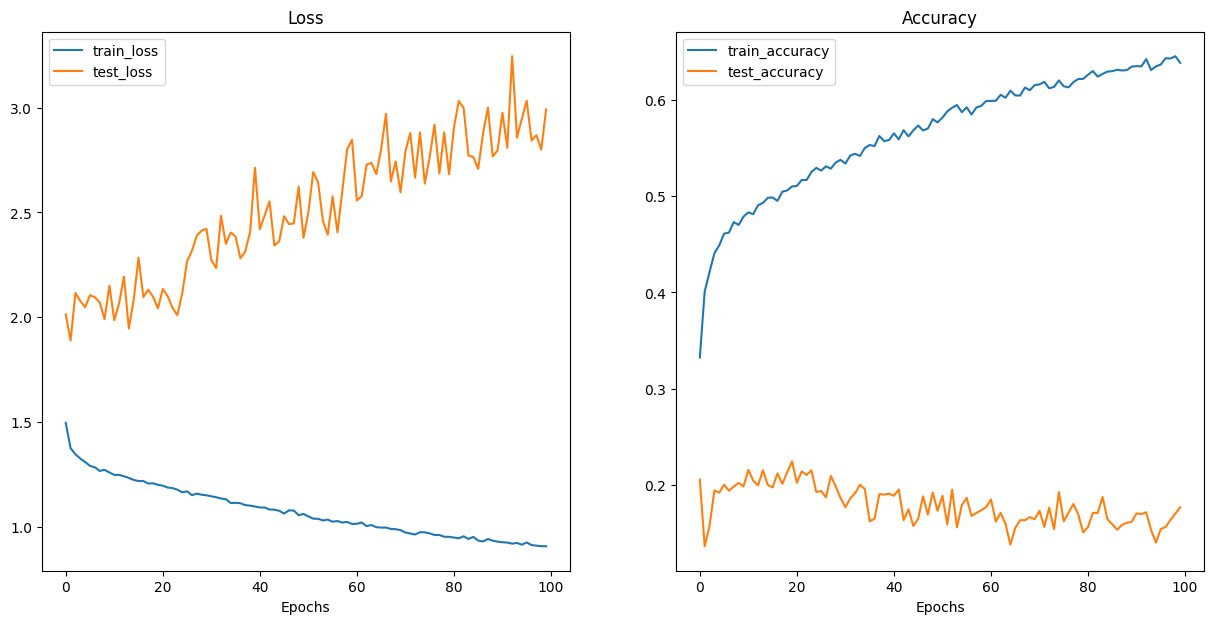

In [14]:
plot_loss_curves(model_results)

## Zapisanie modelu

In [15]:
model_save_path = "../models/cnn_lstm_model_crema.pth"

torch.save(obj=model.state_dict(),
             f=model_save_path)